In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [2]:
#wczytanie danych
data = pd.read_excel("dane_do_wczytania.xlsx")
#ustawiamy kolumnę "wojewodztwo" jako index
#inplace powoduje że modyfikujemy DataFrame, a nie tworzymy nowy
data.set_index("wojewodztwo",inplace=True)
#usuwamy nazwę indexu
data.index.names = [None]
#data

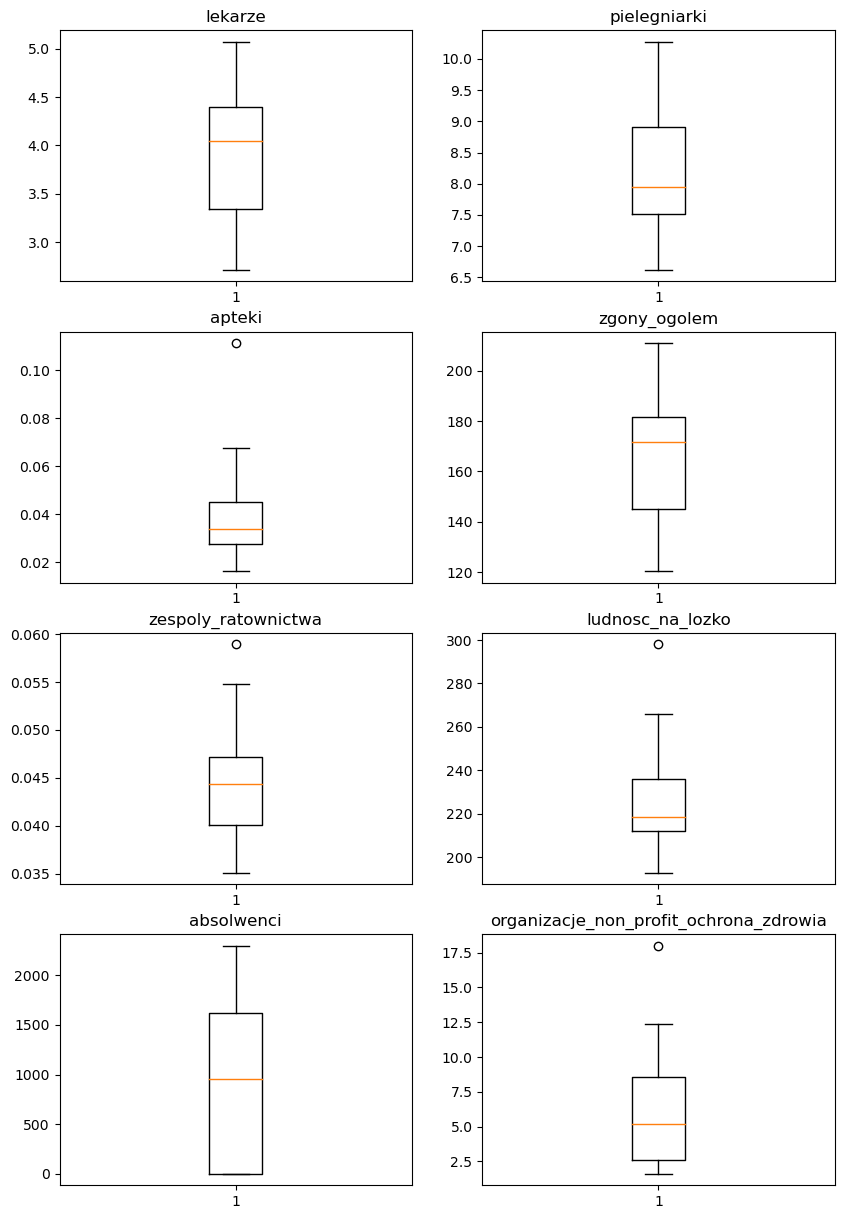

In [3]:
#podstawowe statystyki, wykresy, wartości odstające
#wykresy pudełkowe 
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(10,15))
k = 0
for i in range(int(len(data.columns)/2)):
    for j in range(int(len(data.columns)/(len(data.columns)/2))):
        axes[i,j].boxplot(data[data.columns[k]])
        axes[i,j].set_title(data.columns[k])
        k+=1
    


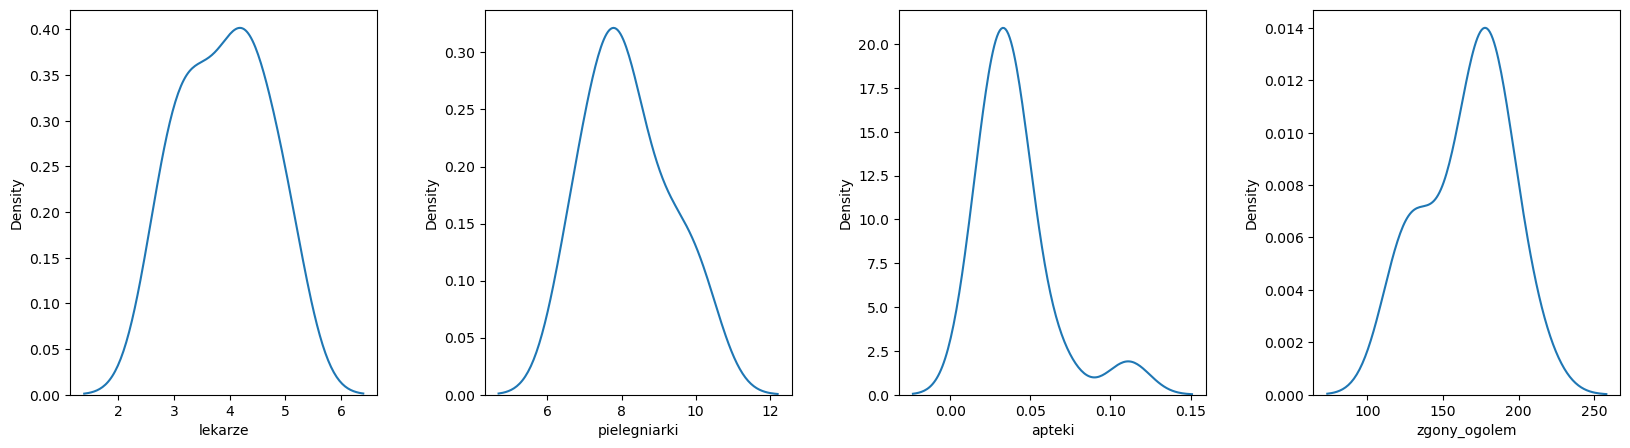

In [4]:
#kde plots row 1
fig, axes = plt.subplots(ncols=4,figsize=(20,5))
plt.subplots_adjust(wspace=0.35)
for i, column in enumerate(data.columns[:4]):
    sns.kdeplot(data[column], ax=axes[i])

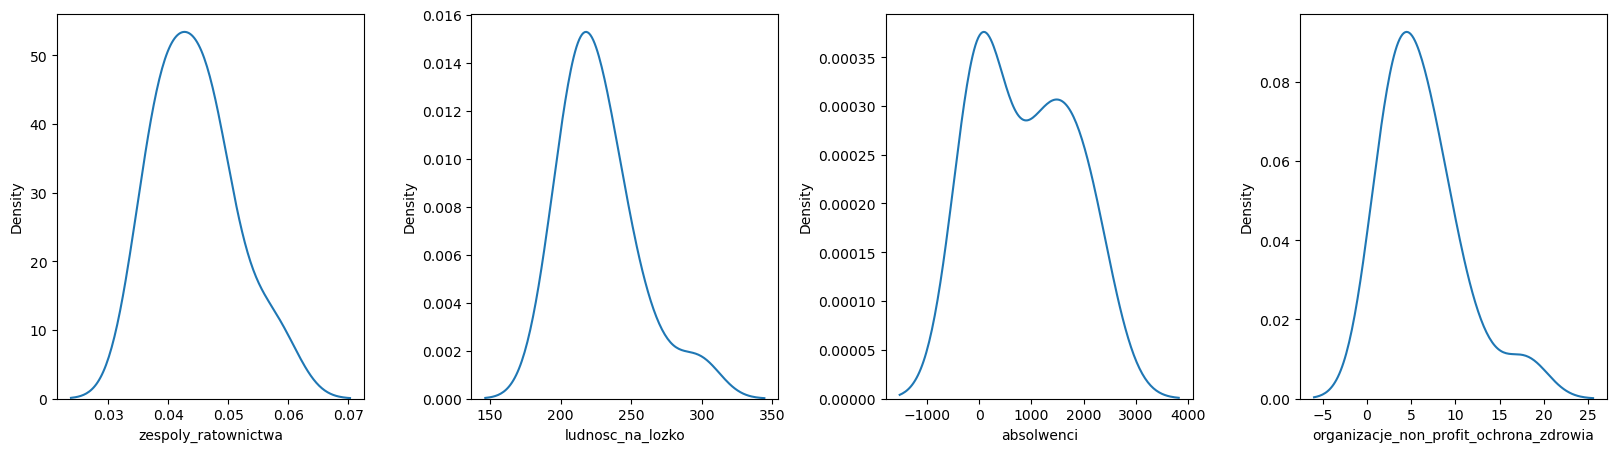

In [5]:
#kde plots row 2
fig, axes = plt.subplots(ncols=4,figsize=(20,5))
plt.subplots_adjust(wspace=0.35)
for i, column in enumerate(data.columns[4:]):
    sns.kdeplot(data[column], ax=axes[i])

In [6]:
data.describe()

,lekarze,pielegniarki,apteki,zgony_ogolem,zespoly_ratownictwa,ludnosc_na_lozko,absolwenci,organizacje_non_profit_ochrona_zdrowia
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,3.896445,8.172659,0.039537,165.631250,0.044412,227.437500,874.812500,6.243750
std,0.769269,1.121566,0.022998,27.146411,0.006595,26.857572,881.159631,4.389224
min,2.712356,6.618800,0.016341,120.300000,0.035143,193.000000,0.000000,1.600000
25%,3.339254,7.510276,0.027817,144.900000,0.040048,212.250000,0.000000,2.625000
50%,4.050560,7.939782,0.034067,171.850000,0.044317,218.500000,951.500000,5.150000
75%,4.394194,8.904232,0.045117,181.750000,0.047194,236.250000,1614.750000,8.525000
max,5.073475,10.275409,0.111246,211.100000,0.058922,298.000000,2298.000000,18.000000


In [7]:
#zamiana zmiennych na stymulanty
print(data.columns)
#liczba lekarzy - stymulanta
#liczba pielegniarek - stymulanta
#liczba aptek - stymulanta
#zgony ogolem - destymulanta
#zespoly ratownictwa medycznego - stymulanta
#liczba ludnosci na lozko szpitalne - destymulanta
#absolwenci - stymulanta
#organizacje non profit - nominanta, 8%

Index(['lekarze', 'pielegniarki', 'apteki', 'zgony_ogolem',
       'zespoly_ratownictwa', 'ludnosc_na_lozko', 'absolwenci',
       'organizacje_non_profit_ochrona_zdrowia'],
      dtype='object')


In [8]:
data["ludnosc_na_lozko"] = data["ludnosc_na_lozko"] * -1
data["zgony_ogolem"] = data["zgony_ogolem"] * -1
nominanta = 9
for i in range(len(data["organizacje_non_profit_ochrona_zdrowia"])):
    if data["organizacje_non_profit_ochrona_zdrowia"][i]==nominanta :
        data["organizacje_non_profit_ochrona_zdrowia"][i]=1
    elif data["organizacje_non_profit_ochrona_zdrowia"][i]>nominanta :
        data["organizacje_non_profit_ochrona_zdrowia"][i] = 1/(data["organizacje_non_profit_ochrona_zdrowia"][i]-nominanta+1)
    else:
        data["organizacje_non_profit_ochrona_zdrowia"][i] = -1/(data["organizacje_non_profit_ochrona_zdrowia"][i]-nominanta-1)


In [9]:
#standaryzacja danych I
data_std = data.copy()
col_names = data_std.columns
for column in col_names:
    mean = np.mean(data_std[column])
    sd = np.std(data_std[column])
    for i in range(len(data_std[column])):
        data_std[column][i] = (data_std[column][i] - mean)/sd

In [10]:
#standaryzacja danych II (dla TOPSIS)
data_std_TOPSIS = data.copy()
col_names = data_std_TOPSIS.columns
for column in col_names:
    suma = np.sum(data_std_TOPSIS[column]**2)
    for i in range(len(data_std_TOPSIS[column])):
        data_std_TOPSIS[column][i] = data_std_TOPSIS[column][i]/np.sqrt(suma)

In [11]:
#metoda standaryzowanych sum

#przypisanie wag
weights = pd.DataFrame({"Name":col_names, "Weights":[0.25,0.1,0.1,0.2,0.075,0.075,0.15,0.05,]})
weights = weights.transpose()
weights.rename(columns=weights.iloc[0],inplace=True)
weights.drop(weights.index[0],inplace=True)
#np.sum(weights["Weights"])

#miara syntetyczna
S1 = np.empty(len(data_std.index))
for i in range(len(data_std.index)):
    suma_czesciowa = 0
    for column in data_std.columns:
        suma_czesciowa += data_std[column][i]*weights[column][0]
    S1[i] = suma_czesciowa

In [12]:
#wyliczenie i dołączenie standaryzowanej miary syntetycznej do pierwotnej tabeli
miara_synt = pd.DataFrame(S1)
miara_synt.rename(columns={0:"S1"},inplace=True)
min_s1 = min(miara_synt["S1"])
s1_min_diff = miara_synt["S1"] - min_s1
miara_synt_std = s1_min_diff/np.max(s1_min_diff)

standaryzowane_sumy = data_std.copy()
standaryzowane_sumy.insert(len(standaryzowane_sumy.columns),"S1",miara_synt["S1"].values)
standaryzowane_sumy.insert(len(standaryzowane_sumy.columns),"S2",miara_synt_std.values)

standaryzowane_sumy.sort_values("S2",inplace=True,ascending=False)
standaryzowane_sumy.drop(columns=standaryzowane_sumy.columns[range(9)])


,S2
MAZOWIECKIE,1.000000
SLASKIE,0.886398
PODLASKIE,0.821959
LUBELSKIE,0.778469
LODZKIE,0.777691
DOLNOSLASKIE,0.751242
MALOPOLSKIE,0.736129
POMORSKIE,0.587049
WIELKOPOLSKIE,0.547890
PODKARPACKIE,0.401121


In [13]:
#metoda Hellwiga
wzorzec = np.empty(len(data_std.columns))

i=0
for column in data_std.columns:
    wzorzec[i] = max(data_std[column])
    i+=1

di = np.empty(len(data_std.index))
for i in range(len(data_std.index)):
    suma=0
    j=0
    for column in data_std.columns:
        suma += weights[column][0]*(data_std[column][i] - wzorzec[j])**2
        j+=1
    di[i]=np.sqrt(suma)

d0 = np.mean(di) + 2*np.std(di)
si = 1 - di/d0

metoda_Hellwiga = data_std.copy()
metoda_Hellwiga.insert(len(metoda_Hellwiga.columns),"Si",si)

metoda_Hellwiga.sort_values("Si",inplace=True,ascending=False)
metoda_Hellwiga.drop(columns=metoda_Hellwiga.columns[range(8)])



,Si
DOLNOSLASKIE,0.405122
MAZOWIECKIE,0.397152
SLASKIE,0.384435
PODLASKIE,0.359871
MALOPOLSKIE,0.357344
LUBELSKIE,0.346385
LODZKIE,0.325131
POMORSKIE,0.227327
WIELKOPOLSKIE,0.219074
PODKARPACKIE,0.217807


In [14]:
#metoda TOPSIS
wzorzec = np.empty(len(data_std_TOPSIS.columns))
antywzorzec = np.empty(len(data_std_TOPSIS.columns))

i=0
for column in data_std_TOPSIS.columns:
    wzorzec[i] = max(data_std_TOPSIS[column])
    antywzorzec[i] = min(data_std_TOPSIS[column])
    i+=1

dip = np.empty(len(data_std_TOPSIS.index)) #di+ (plus)
dim = np.empty(len(data_std_TOPSIS.index)) #di- (minus)
for i in range(len(data_std_TOPSIS.index)):
    suma_p=0
    suma_m=0
    j=0
    for column in data_std_TOPSIS.columns:
        suma_p += weights[column][0]*(data_std_TOPSIS[column][i] - wzorzec[j])**2
        suma_m += weights[column][0]*(data_std_TOPSIS[column][i] - antywzorzec[j])**2
        j+=1
    dip[i]=np.sqrt(suma_p)
    dim[i]=np.sqrt(suma_m)

R = dim/(dim+dip)

metoda_TOPSIS = data_std_TOPSIS.copy()
metoda_TOPSIS.insert(len(metoda_TOPSIS.columns),"R",R)
metoda_TOPSIS.sort_values("R",inplace=True,ascending=False)
metoda_TOPSIS.drop(columns=metoda_TOPSIS.columns[range(8)])

,R
SLASKIE,0.691835
WIELKOPOLSKIE,0.562609
MAZOWIECKIE,0.543936
LODZKIE,0.528245
DOLNOSLASKIE,0.516026
LUBELSKIE,0.436884
MALOPOLSKIE,0.416272
POMORSKIE,0.411691
PODLASKIE,0.366967
ZACHODNIOPOMORSKIE,0.262830


In [15]:
#metoda sumy rang
data_ranked = data.copy()

for column in data_ranked.columns:
    data_ranked.sort_values(column,inplace=True,ascending=False)
    for i in range(len(data_ranked.index)):
        data_ranked[column][i] = i+1

si = np.empty(len(data_ranked.index))
for i in range(len(data_ranked.index)):
    suma=0
    for column in data_ranked.columns:
        suma+=data_ranked[column][i]*weights[column][0]
    si[i]=suma

metoda_sumy_rang = data_ranked.copy()
metoda_sumy_rang.insert(len(metoda_sumy_rang.columns),"Si",si)
metoda_sumy_rang.sort_values("Si",inplace=True,ascending=True)
metoda_sumy_rang.drop(columns=metoda_sumy_rang.columns[range(8)])


,Si
MAZOWIECKIE,5.350
DOLNOSLASKIE,5.875
LODZKIE,6.400
PODLASKIE,6.400
SLASKIE,6.550
LUBELSKIE,6.925
POMORSKIE,7.575
MALOPOLSKIE,8.075
WIELKOPOLSKIE,8.525
PODKARPACKIE,9.175


In [16]:
#analiza skupień
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.manifold import MDS

In [17]:
#wczytanie danych
data = pd.read_excel("dane_do_wczytania.xlsx")
#ustawiamy kolumnę "wojewodztwo" jako index
#inplace powoduje że modyfikujemy DataFrame, a nie tworzymy nowy
data.set_index("wojewodztwo",inplace=True)
#usuwamy nazwę indexu
data.index.names = [None]
data_std = data.copy()
col_names = data_std.columns
for column in col_names:
    mean = np.mean(data_std[column])
    sd = np.std(data_std[column])
    for i in range(len(data_std[column])):
        data_std[column][i] = (data_std[column][i] - mean)/sd

In [18]:
km = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
km.fit_predict(data_std)
s_score = silhouette_score(data_std, km.labels_, metric='euclidean')
s_score

0.27421944368357054

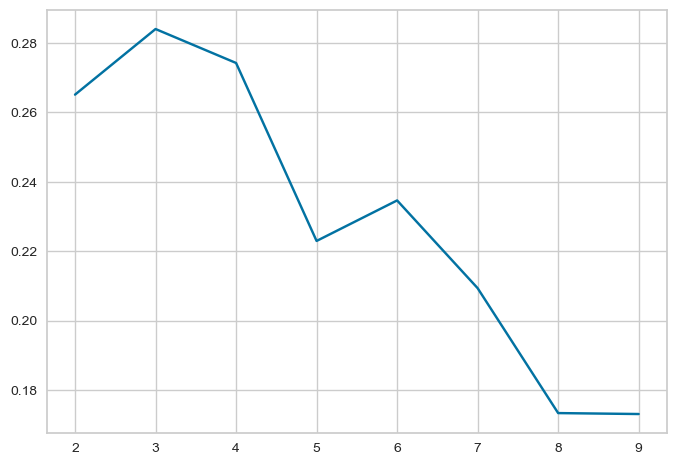

In [19]:
s_scores = []
for i in range(2,10):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit_predict(data_std)
    s_score = silhouette_score(data_std, km.labels_, metric='euclidean')
    s_scores.append(s_score)
plt.plot(range(2,10),s_scores)


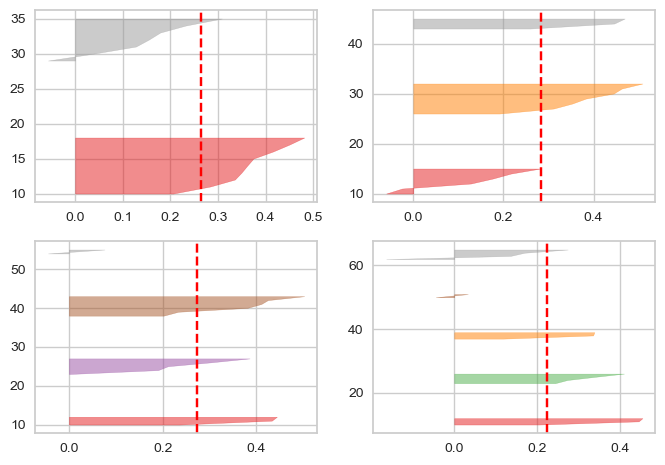

In [20]:
fig, axes = plt.subplots(2,2)
for i in [2,3,4,5]:
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    q, mod = divmod(i,2) #parametry do plotowania 
    visualiser = SilhouetteVisualizer(km, ax=axes[q-1][mod])
    visualiser.fit(data_std)

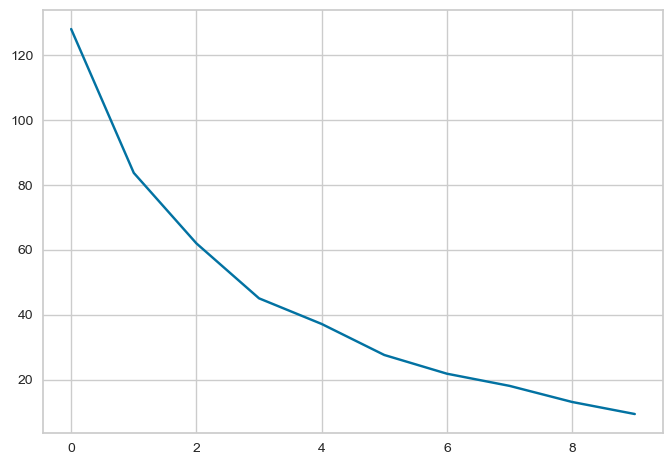

In [21]:
#metoda łokcia
wcss = []
for i in range(1,11):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(data_std)
    wcss.append(km.inertia_)
plt.plot(wcss)

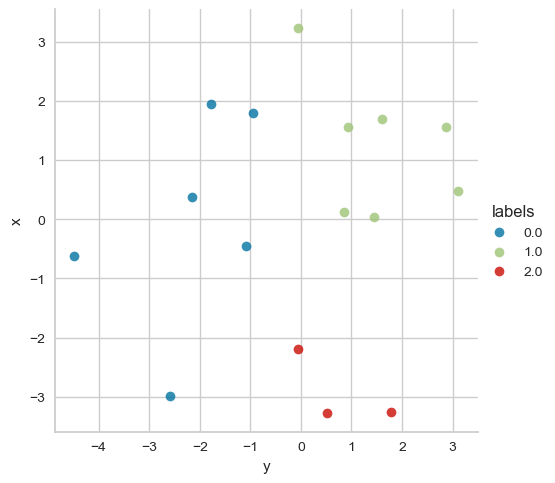

In [26]:
km = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmfit = km.fit(data_std)
data_std_grouped = data_std.copy()
data_std_grouped.insert(len(data_std_grouped.columns),"Group",kmfit.labels_)

mds = MDS(random_state=0)
data_std_2d = mds.fit_transform(data_std)
data_std_2d = np.c_[data_std_2d, kmfit.labels_]
data_std_2d = pd.DataFrame(data_std_2d)
data_std_2d.columns = ["x","y","labels"]
sns.lmplot(x='y',y='x',data=data_std_2d,hue='labels', fit_reg=False)